In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input, LayerNormalization,Activation,Concatenate
from tensorflow.keras.layers import Layer,Add
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from models.skipnet import *
from utils.common import *
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import scipy.io as sio
from skimage.transform import rescale, pyramid_reduce
# from skimage.metrics import structural_similarity as ssim
import h5py
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# filepath1='./data/Data prepare/iceland.mat'
# data=sio.loadmat(filepath1)

# Y20 = data['y20'].astype(np.float32)
# Y10 = data['y10'].astype(np.float32)
# Y60 = data['y60'].astype(np.float32)
# scale = np.max([np.max(Y20),np.max(Y10),np.max(Y60)])
# Y20u=rescale(Y20, scale = 2, multichannel = True)
# Y60u=rescale(Y60, scale = 6, multichannel = True)
# (y10,y20,y60,y20u,y60u)=(Y10,Y20,Y60,Y20u,Y60u)/scale

# X20t=y20[tf.newaxis,:,:,:]
# X10t=y10[tf.newaxis,:,:,:]
# X60t=y60[tf.newaxis,:,:,:]

# X10=GenerateCube(y10,size=24,stride=12) #input
# X20=GenerateCube(y20,size=12,stride=6) #target
# X60=GenerateCube(y60,size=4,stride=2)
# # Xref=y20[2:-2,2:-2,:]
# Xref=y10[2:-2,2:-2,:]  # Xref for 60 m sharpening

In [3]:
filepath1='./data/vietnam.mat'
data=sio.loadmat(filepath1)

Y20 = data['y20'].astype(np.float32)
Y10 = data['y10'].astype(np.float32)
Y60 = data['y60'].astype(np.float32)
scale = np.max([np.max(Y20),np.max(Y10),np.max(Y60)])

# Y10d = np.squeeze(bicubicdown(factor=2)(Y10[tf.newaxis, :, :, :]))
# Y20d = np.squeeze(bicubicdown(factor=2)(Y20[tf.newaxis, :, :, :]))
# Y60d = np.squeeze(bicubicdown(factor=2)(Y60[tf.newaxis, :, :, :]))

Y10d = np.squeeze(downsampler(factor=2, kernel='gaussian', band=10)(Y10[tf.newaxis, :, :, :]))
Y20d = np.squeeze(downsampler(factor=2, kernel='gaussian', band=20)(Y20[tf.newaxis, :, :, :]))
Y60d = np.squeeze(downsampler(factor=2, kernel='gaussian', band=60)(Y60[tf.newaxis, :, :, :]))

Y20u=rescale(Y20d, scale = 2, multichannel = True)
Y60u=rescale(Y60d, scale = 6, multichannel = True)
(y10d,y20d,y60d,y10,y20,y60,y20u,y60u)=(Y10d,Y20d,Y60d,Y10,Y20,Y60,Y20u,Y60u)/scale

X20t=y20d[tf.newaxis,:,:,:]
X10t=y10d[tf.newaxis,:,:,:]
X60t=y60d[tf.newaxis,:,:,:]
Xref=y20[2:-2,2:-2,:]*scale #remove 4 pixels border to compare with other methods

/home/han/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [4]:
# sio.savemat('usa2_rr_data.mat',mdict={'y10':Y10d,'y20':Y20d,'y60':Y60d, 'yref':Y60})

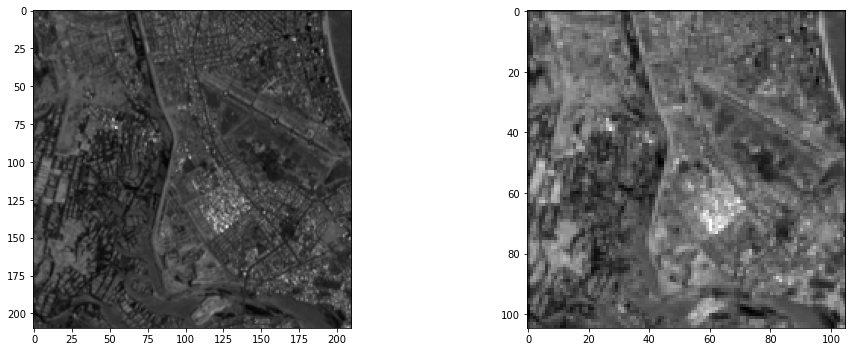

In [5]:
fig1=plt.figure(figsize=(15,5))
plt.subplot(121)             
plt.imshow(y20[:,:,0],cmap='gray')
plt.subplot(122)
plt.imshow(y20d[:,:,0],cmap='gray')
plt.tight_layout()
plt.show()

In [6]:
def sre(y_true,y_pred):  
    SRE_vec=[]
    for i in range(y_true.shape[-1]):
        SRE_vec.append(10.*tf.math.log(tf.reduce_sum(tf.square(y_true[:,:,i]))
                                       /tf.reduce_sum(tf.square(y_true[:,:,i]-y_pred[:,:,i])))/tf.math.log(10.))
    return tf.reduce_mean(SRE_vec)

In [7]:
b20 = Y20.shape[-1]
b60 = Y60.shape[-1]
b10 = Y10.shape[-1]
outchannel = 12
input_20 = Input((None,None,b20))
input_60 = Input((None,None,b60))
input_10 = Input((None,None,b10))
# input_20 = Input(Y20d.shape)
# input_60 = Input(Y60d.shape)
# input_10 = Input(Y10d.shape)

In [8]:
n=3
#begin first net
out=convbn(input_60,128)
up60 = UpSampling2D(size=(3,3),interpolation='bilinear')(out)
out=convbn(input_20,128)
out = convbn(Add()([out,up60]),128)
out20=input_20
skip=[]
for i in range(n):
    out20=convbn(input_20,128)
    out=convbn(Add()([out,out20]),128)
    skip.append(out20)
skip.reverse()
for i in range(n):
    if i==0:
        out = convbn(out,128)
    else:
        out20=convbn(Add()([out20,skip[i]]),128)
        out=convbn(Add()([out,out20]),128)

out=UpSampling2D(size=(2,2),interpolation='bilinear')(out)
out20_2=convbn(UpSampling2D(size=(2,2),interpolation='bilinear')(input_20),128)
out10=convbn(input_10,128)
out=convbn(Add()([out,out10,out20_2]),128)
out10=input_10
skips=[]
for i in range(2): 
    out10=convbn(out10,128)
    out=convbn(Add()([out,out10]),128)  
    skips.append(out10)
skips.reverse()
for i in range(2):
    if i==0:
        out = convbn(out,128)
    else:
        out10=convbn(Add()([out10,skips[i]]),128)
        out=convbn(Add()([out,out10]),128)  

out = Conv2D(12,1,activation='sigmoid',padding='same')(out)
hr_model=Model([input_60,input_20,input_10],out)
out60=out[:,:,:,0:2]
out20=out[:,:,:,2:8]
out10=out[:,:,:,8:12]
# #Downsampling
down20=downsampler(factor=2,kernel='gaussian',band=20)(out20)
down60=downsampler(factor=6,kernel='gaussian',band=60)(out60)
# down20=bicubicdown(factor=2)(out20)
# down60=bicubicdown(factor=6)(out60)
sr_model=Model(inputs=[input_60,input_20,input_10],outputs=[down60,down20,out10])

In [9]:
opti = tf.keras.optimizers.Adam(learning_rate=0.001)
sr_model.compile(optimizer = opti, loss = 'mae')

In [10]:
fit_params = {
    'x': [X60t,X20t,X10t],
    'y': [X60t,X20t,X10t],
    'epochs': 10,
    'batch_size': 1,
    'verbose': 0,
}

In [11]:
# modelpath = 'trained models/reduce scale/sep-usa2-rr'
iteration=1001;
cur_sre=0
totloss=[]
totsre=[]
for i in range(iteration):   
    h=sr_model.fit(**fit_params)
    img_hr_out = hr_model.predict([X60t,X20t,X10t], steps=1)[0]
#     if sre(Xref,img_hr_out[2:-2,2:-2,0:2])>cur_sre:
#         cur_sre=sre(Xref,img_hr_out[2:-2,2:-2,0:2])
#         hr_model.save(modelpath)
#     if (i%10)==0:
#         print(sre(img_hr_out[:,:,0:2],y60))
#         plt.subplot(221)
#         plt.imshow(img_hr_out[:,:,0],cmap='gray')
#         plt.subplot(222)
#         plt.imshow(y60[:,:,0],cmap='gray')
#         plt.subplot(223)
#         plt.imshow(img_hr_out[:,:,1],cmap='gray')
#         plt.subplot(224)
#         plt.imshow(y60[:,:,1],cmap='gray')
#         plt.show()
#     totloss.append(h.history['loss'][-1])
    totsre.append(sre(Xref,img_hr_out[2:-2,2:-2,2:8]*scale))

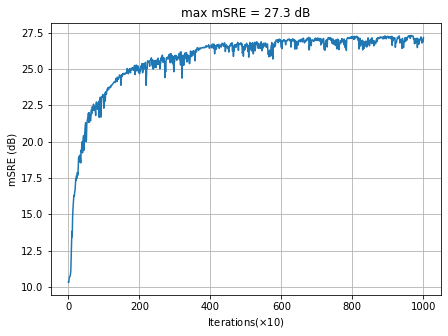

27.304903


In [12]:
# np.save('ice20si-bm5',totsre)
fig=plt.figure(figsize=(7,5))
plt.plot(totsre)
plt.xlabel('Iterations' r'$(\times10)$')
plt.ylabel('mSRE (dB)')
plt.title('max mSRE = '+str(round(np.max(totsre),2))+' dB')
plt.grid()
plt.show()
# fig.savefig('vietnam20000iteration.pdf')
print(np.max(totsre))

In [13]:
# plt.figure(figsize=(15,15))
# plt.subplot(131)
# plt.imshow(img_hr_out[:,:,1],cmap='gray')
# plt.subplot(132)
# plt.imshow(y60[:,:,1],cmap='gray')
# # plt.axis('off')
# plt.tight_layout()
# plt.show()

In [14]:
# bestmodel=tf.keras.models.load_model(modelpath)
# img_out=bestmodel.predict([X60t,X20t,X10t])[0]*scale

In [15]:
print(sreCal(Xref,img_hr_out[2:-2,2:-2,2:8]*scale))
# print(sreCal(y10d*scale,img_hr_out[:,:,8::]))

(27.15124649647726, array([27.93948562, 27.76892608, 28.33663022, 28.51229654, 27.36052213,
       22.98961839]))


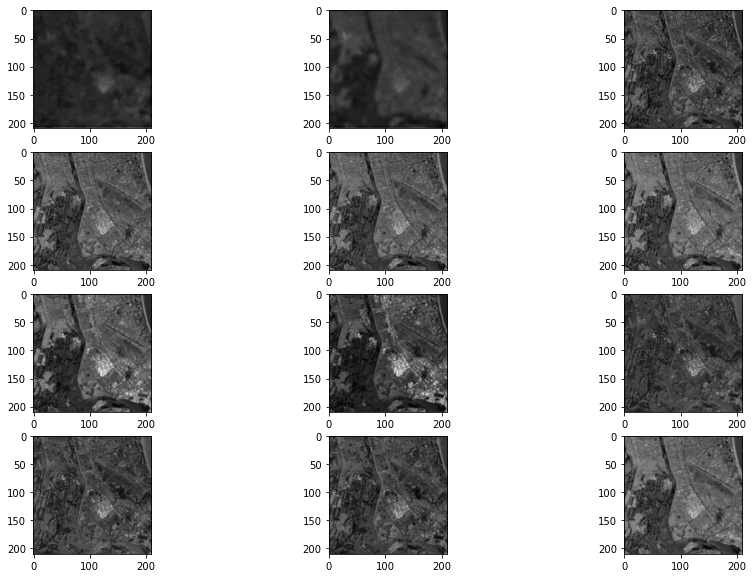

In [16]:
fig1=plt.figure(figsize=(15, 10))
columns = 3
rows = 4
for i in range(1, columns*rows +1):
    img = img_hr_out[:,:,i-1]
    fig1.add_subplot(rows, columns, i)
    plt.imshow(img,cmap='gray')
plt.show()


In [17]:
# sio.savemat('usa2_se_rr.mat',mdict={'xout':img_out})